In [1]:
from __future__ import print_function

import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

In [14]:
# Training settings
epochs = 70
lr = 3e-5
gamma = 0.7
seed = 42

In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [16]:
device = 'cuda'

In [17]:
train_dataset_dir = Path('data/train')
val_dataset_dir = Path('data/val')

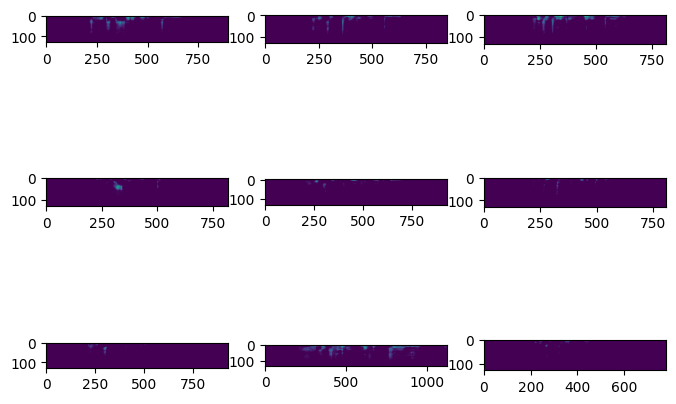

In [18]:
files = glob.glob('data/*/*/*.png')
random_idx = np.random.randint(1, len(files), size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(files[idx])
    ax.imshow(img)

In [19]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [20]:
train_data = datasets.ImageFolder(train_dataset_dir,train_transforms)
valid_data = datasets.ImageFolder(val_dataset_dir, val_transforms)

In [21]:
train_loader = DataLoader(dataset = train_data, batch_size=16, shuffle=True ,num_workers=os.cpu_count())
valid_loader = DataLoader(dataset = valid_data, batch_size=16, shuffle=True ,num_workers=os.cpu_count())

In [22]:
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [23]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=8)
model.to("cuda:0")

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)              

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.2020 - acc: 0.1590 - val_loss : 1.9703 - val_acc: 0.2188



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.9728 - acc: 0.2306 - val_loss : 1.9016 - val_acc: 0.2584



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.9261 - acc: 0.2409 - val_loss : 2.0334 - val_acc: 0.2141



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.9021 - acc: 0.2740 - val_loss : 2.0318 - val_acc: 0.1867



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.9004 - acc: 0.2656 - val_loss : 2.2906 - val_acc: 0.2131



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.8721 - acc: 0.2720 - val_loss : 1.9605 - val_acc: 0.2755



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.8439 - acc: 0.2905 - val_loss : 2.1104 - val_acc: 0.2323



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.8551 - acc: 0.2652 - val_loss : 2.2327 - val_acc: 0.1925



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.8391 - acc: 0.2673 - val_loss : 2.3613 - val_acc: 0.1878



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.8299 - acc: 0.2819 - val_loss : 2.2903 - val_acc: 0.1685



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 11 - loss : 1.8042 - acc: 0.2856 - val_loss : 2.4089 - val_acc: 0.1674



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.7766 - acc: 0.2949 - val_loss : 2.2568 - val_acc: 0.1755



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 13 - loss : 1.8020 - acc: 0.2833 - val_loss : 2.4844 - val_acc: 0.1593



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 14 - loss : 1.7543 - acc: 0.3141 - val_loss : 2.2358 - val_acc: 0.1765



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 15 - loss : 1.7546 - acc: 0.3209 - val_loss : 2.4912 - val_acc: 0.1604



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 16 - loss : 1.7502 - acc: 0.3274 - val_loss : 2.2759 - val_acc: 0.1648



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 17 - loss : 1.7184 - acc: 0.3250 - val_loss : 2.7992 - val_acc: 0.1562



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 18 - loss : 1.7060 - acc: 0.3404 - val_loss : 2.3492 - val_acc: 0.2242



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 19 - loss : 1.6863 - acc: 0.3355 - val_loss : 1.9623 - val_acc: 0.2459



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 20 - loss : 1.6969 - acc: 0.3502 - val_loss : 2.3124 - val_acc: 0.1711



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 21 - loss : 1.6603 - acc: 0.3451 - val_loss : 2.2767 - val_acc: 0.1885



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 22 - loss : 1.6628 - acc: 0.3488 - val_loss : 2.3035 - val_acc: 0.1864



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 23 - loss : 1.6612 - acc: 0.3506 - val_loss : 2.3546 - val_acc: 0.2312



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 24 - loss : 1.6294 - acc: 0.3729 - val_loss : 2.1473 - val_acc: 0.2174



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 25 - loss : 1.6490 - acc: 0.3604 - val_loss : 2.6066 - val_acc: 0.1609



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 26 - loss : 1.6204 - acc: 0.3683 - val_loss : 2.1313 - val_acc: 0.2131



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 27 - loss : 1.6227 - acc: 0.3642 - val_loss : 2.1029 - val_acc: 0.2713



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 28 - loss : 1.6017 - acc: 0.3749 - val_loss : 2.0386 - val_acc: 0.2700



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 29 - loss : 1.6031 - acc: 0.3852 - val_loss : 2.4177 - val_acc: 0.1971



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 30 - loss : 1.5607 - acc: 0.3855 - val_loss : 3.4427 - val_acc: 0.1734



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 31 - loss : 1.5833 - acc: 0.3790 - val_loss : 2.1241 - val_acc: 0.2643



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 32 - loss : 1.5736 - acc: 0.3863 - val_loss : 2.2846 - val_acc: 0.2323



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 33 - loss : 1.5587 - acc: 0.3902 - val_loss : 2.3353 - val_acc: 0.1932



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 34 - loss : 1.5556 - acc: 0.3999 - val_loss : 2.2442 - val_acc: 0.2440



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 35 - loss : 1.5353 - acc: 0.4106 - val_loss : 2.5067 - val_acc: 0.1958



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 36 - loss : 1.5027 - acc: 0.4283 - val_loss : 2.3410 - val_acc: 0.2170



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 37 - loss : 1.5104 - acc: 0.4079 - val_loss : 3.0637 - val_acc: 0.1833



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 38 - loss : 1.5226 - acc: 0.4086 - val_loss : 2.5628 - val_acc: 0.1708



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 39 - loss : 1.4951 - acc: 0.4342 - val_loss : 2.6258 - val_acc: 0.2151



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 40 - loss : 1.4649 - acc: 0.4357 - val_loss : 2.8637 - val_acc: 0.2060



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 41 - loss : 1.4660 - acc: 0.4334 - val_loss : 2.9175 - val_acc: 0.1774



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 42 - loss : 1.4343 - acc: 0.4444 - val_loss : 2.7241 - val_acc: 0.1937



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 43 - loss : 1.4408 - acc: 0.4358 - val_loss : 2.5151 - val_acc: 0.1935



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 44 - loss : 1.4227 - acc: 0.4544 - val_loss : 2.4047 - val_acc: 0.2266



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 45 - loss : 1.4368 - acc: 0.4532 - val_loss : 2.3700 - val_acc: 0.2604



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 46 - loss : 1.3952 - acc: 0.4671 - val_loss : 2.7430 - val_acc: 0.2200



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 47 - loss : 1.3832 - acc: 0.4566 - val_loss : 3.0617 - val_acc: 0.1903



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 48 - loss : 1.3809 - acc: 0.4663 - val_loss : 2.7968 - val_acc: 0.1914



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 49 - loss : 1.3423 - acc: 0.4949 - val_loss : 2.8955 - val_acc: 0.2042



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 50 - loss : 1.3518 - acc: 0.4721 - val_loss : 2.8429 - val_acc: 0.2560



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 51 - loss : 1.3519 - acc: 0.4821 - val_loss : 2.4897 - val_acc: 0.2312



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 52 - loss : 1.3379 - acc: 0.4932 - val_loss : 2.4940 - val_acc: 0.2313



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 53 - loss : 1.3175 - acc: 0.5001 - val_loss : 3.0765 - val_acc: 0.2253



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 54 - loss : 1.2923 - acc: 0.5135 - val_loss : 2.8284 - val_acc: 0.2732



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 55 - loss : 1.3011 - acc: 0.5065 - val_loss : 2.2632 - val_acc: 0.2836



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 56 - loss : 1.2877 - acc: 0.5092 - val_loss : 2.1709 - val_acc: 0.2701



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 57 - loss : 1.2685 - acc: 0.5137 - val_loss : 2.6295 - val_acc: 0.2653



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 58 - loss : 1.2539 - acc: 0.5166 - val_loss : 2.3217 - val_acc: 0.2438



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 59 - loss : 1.2344 - acc: 0.5181 - val_loss : 3.1964 - val_acc: 0.2081



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 60 - loss : 1.2207 - acc: 0.5327 - val_loss : 2.7927 - val_acc: 0.2416



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 61 - loss : 1.2215 - acc: 0.5315 - val_loss : 2.5097 - val_acc: 0.2339



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 62 - loss : 1.2166 - acc: 0.5315 - val_loss : 3.6704 - val_acc: 0.2209



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 63 - loss : 1.1891 - acc: 0.5442 - val_loss : 3.3295 - val_acc: 0.1938



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 64 - loss : 1.1496 - acc: 0.5658 - val_loss : 2.7786 - val_acc: 0.2211



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 65 - loss : 1.1548 - acc: 0.5553 - val_loss : 2.8617 - val_acc: 0.2521



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 66 - loss : 1.1869 - acc: 0.5512 - val_loss : 2.8911 - val_acc: 0.2110



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 67 - loss : 1.1544 - acc: 0.5524 - val_loss : 2.7908 - val_acc: 0.2487



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 68 - loss : 1.1597 - acc: 0.5675 - val_loss : 2.9997 - val_acc: 0.2188



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 69 - loss : 1.0989 - acc: 0.5690 - val_loss : 2.7586 - val_acc: 0.2802



  0%|          | 0/147 [00:00<?, ?it/s]

Epoch : 70 - loss : 1.1290 - acc: 0.5723 - val_loss : 3.2718 - val_acc: 0.2120



In [26]:
print("hoge")

hoge


In [27]:
device2 = torch.device('cpu')

In [28]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []

In [29]:
for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

/tmp/ipykernel_374206/1204376373.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


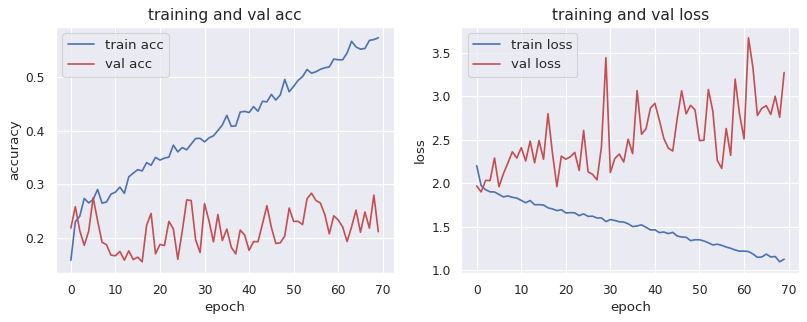

In [30]:
#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()